In [7]:
import os
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer, TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from pathlib import Path, PureWindowsPath
pd.set_option('display.max_colwidth', 30)
pd.set_option('display.min_rows', 10)
pd.set_option('display.max_rows', 10)
pd.set_option('display.max_colwidth', None) #afficher texte entier dans dataframe

In [8]:
path = PureWindowsPath(os.getcwd() + "\\data\\input\\data.parquet")
path = path.as_posix()
corpus = pd.read_parquet(path) #engine="fastparquet"
# corpus

zeros_subset = corpus.loc[corpus["category_bin"] == 0, :]
ones_subset = corpus.loc[corpus["category_bin"] == 1, :]
number_of_minority_class = len(zeros_subset)
sampled_ones = ones_subset.sample(number_of_minority_class, random_state=42)
print(sampled_ones.shape)
corpus = pd.concat([sampled_ones, zeros_subset], ignore_index=True)
corpus = corpus.sample(frac=1).reset_index(drop=True)
corpus.index = list(range(len(corpus)))
corpus["id"] = corpus.index	#creation de l'id seulement apres equilibrage des classes et melange aleatoire
print(corpus["category_bin"].value_counts())
# corpus

(1825, 6)
1    1825
0    1825
Name: category_bin, dtype: int64


In [9]:
X = corpus["message_preprocessed"]
y = corpus["category"]
# y = corpus["category_bin"]
indices = corpus["id"]
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y)
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(X, y, indices, test_size=0.33, random_state=42)
tfidf_vectorizer = TfidfVectorizer()
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
# indices_test

In [10]:
# Poids globaux (dans le corpus) des mots tfidf
print("X_train_tfidf.shape =", X_train_tfidf.shape)
n_words = X_train_tfidf.shape[1]
scores_tfidf = pd.DataFrame({"id":range(n_words), "words":tfidf_vectorizer.get_feature_names(), "idf":tfidf_vectorizer.idf_})
scores_tfidf = scores_tfidf.sort_values("idf", ascending=False)
print("moyenne des poids idf =", np.mean(scores_tfidf["idf"]))
print("ecart-type des poids idf =", np.std(scores_tfidf["idf"]))
with pd.option_context("display.max_rows", 100):
    display(scores_tfidf)
# scores_tfidf.to_csv("./data/output/scores_tfidf_train.csv")

X_train_tfidf.shape = (2445, 9568)
moyenne des poids idf = 7.524316977867511
ecart-type des poids idf = 0.879321234116492


c:\Users\eupho\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,id,words,idf
0,0,aaaayaajpgpadqthechildofthecovenantorhowchristianparentsshouldtrainuptheirhouseholds,8.109062
5232,5232,mankind,8.109062
5247,5247,marcelhttpswwwxlcomarticles,8.109062
5246,5246,marcelhttplarevuereformeenetarticlerrnla,8.109062
5245,5245,marcel,8.109062
...,...,...,...
1313,1313,cette,2.867315
6355,6355,plus,2.719990
9545,9545,être,2.673159
1566,1566,comme,2.664482


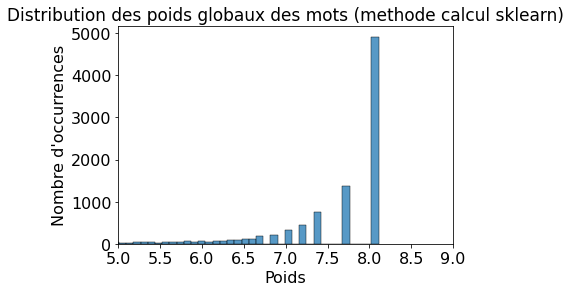

In [11]:
# Distribution des poids globaux des mots (calcules avec sklearn)
path = PureWindowsPath(os.getcwd() + "\\data\\output\\words_weights_distribution.png")
path = path.as_posix()

sb.histplot(data=scores_tfidf, x="idf")
# plt.yscale('log')
plt.xlabel("Poids", size=16)
plt.ylabel("Nombre d'occurrences", size=16)
plt.title("Distribution des poids globaux des mots (methode calcul sklearn)", size=17)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.rcParams["figure.figsize"] = (10, 6)
plt.xlim(5, 9)
plt.savefig(path)
plt.show()

In [12]:
# Calcul manuel des poids
print("X_train_tfidf.shape =", X_train_tfidf.shape)
words_weights = X_train_tfidf.sum(axis=0)
print("words_weights.shape =", words_weights.shape)
print(words_weights)
print(words_weights.shape)
words_weights = np.ravel(words_weights)
print(words_weights)
print(words_weights.shape)
# words_weights[:10]
np.set_printoptions(suppress=True)
np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})
np.unique(words_weights).shape
np.max(words_weights)
np.min(words_weights)
print("words_weights.shape =", words_weights.shape)
words_weights

X_train_tfidf.shape = (2445, 9568)
words_weights.shape = (1, 9568)
[[0.28306381 0.60001445 0.14122157 ... 0.33283389 0.30116033 0.13854784]]
(1, 9568)
[0.28306381 0.60001445 0.14122157 ... 0.33283389 0.30116033 0.13854784]
(9568,)
words_weights.shape = (9568,)


array([0.283, 0.600, 0.141, ..., 0.333, 0.301, 0.139])

In [13]:
# scores_tfidf["manuel_weights"] = words_weights
print("corpus.shape =", corpus.shape)
print("scores_tfidf.shape =", scores_tfidf.shape)
scores_tfidf

corpus.shape = (3650, 6)
scores_tfidf.shape = (9568, 3)


,id,words,idf
0,0,aaaayaajpgpadqthechildofthecovenantorhowchristianparentsshouldtrainuptheirhouseholds,8.109062
5232,5232,mankind,8.109062
5247,5247,marcelhttpswwwxlcomarticles,8.109062
5246,5246,marcelhttplarevuereformeenetarticlerrnla,8.109062
5245,5245,marcel,8.109062
...,...,...,...
1313,1313,cette,2.867315
6355,6355,plus,2.719990
9545,9545,être,2.673159
1566,1566,comme,2.664482


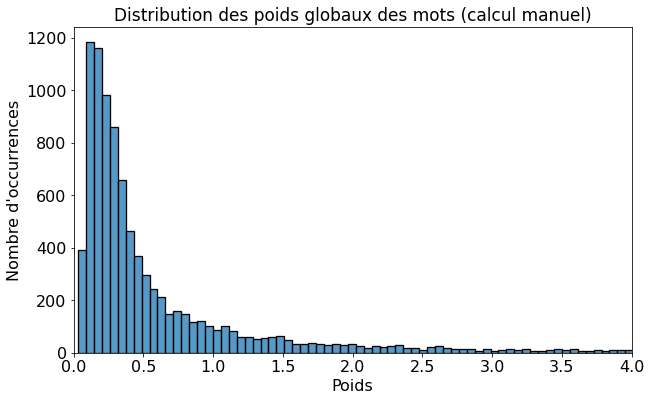

In [14]:
# Distribution des poids globaux des mots (calcules avec a la main)
# Pour chaque phrase, y a-t-il beaucoup de mots qui ont ete trouves et qui ont influences positivement la prediction ?
path = PureWindowsPath(os.getcwd() + "\\data\\output\\words_weights_distribution_manuel.png")
path = path.as_posix()

# sb.histplot(words_weights[:100000])
sb.histplot(words_weights, edgecolor="black", linewidth=1.3)
# plt.yscale('log')
plt.xlabel("Poids", size=16)
plt.ylabel("Nombre d'occurrences", size=16)
plt.title("Distribution des poids globaux des mots (calcul manuel)", size=17)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.rcParams["figure.figsize"] = (10, 6)
plt.xlim(0, 4)
plt.savefig(path)
plt.show()

In [15]:
# Calcul des poids locaux des mots (poids des mots pour chaque document)
# Technique : ne plus travailler sur la matrice creuse mais la convertir en numpy array X_train_tfidf.toarray()
# pour travailler dessus
threshold_score = 4.5
col_top_words = [] #liste des top words pour chaque exemple du corpus (partie train)

feature_names = tfidf_vectorizer.get_feature_names_out()
X_train_tfidf_arr = X_train_tfidf.toarray()
idx_vocab = np.argsort(X_train_tfidf_arr, axis=1)
vocab = tfidf_vectorizer.vocabulary_
vocab_inv = {v: k for k, v in vocab.items()}
idx_top_words = idx_vocab[:,-10:]
idx_top_words = np.flip(idx_top_words, axis=1)

col_top_words = []
for idx_row in range(len(idx_top_words)):
    row_matrix_top_words_idx = idx_top_words[idx_row]
    doc_top_words = []
    for idx_word in row_matrix_top_words_idx:
        word = vocab_inv[idx_word]
        score = str(round(X_train_tfidf_arr[idx_row, idx_word], 3))
        doc_top_words.append(word + " (" + score + ")")
    col_top_words.append(doc_top_words)

df_train = pd.DataFrame(X_train_tfidf_arr, columns = feature_names)
df_train["id"] = list(indices_train)
df_train["top_words"] = col_top_words
df_train.sort_values("id", inplace=True)
df_train["message"] = corpus.iloc[indices_train].sort_values("id")["message"].values

display(df_train[["message", "top_words"]])

,message,top_words
2197,L’unique critère pour faire partie du peuple visible de Dieu est que Dieu lui- même nous y ait appelé par une promesse.,"[lunique (0.499), critère (0.394), appelé (0.327), visible (0.3), peuple (0.275), partie (0.271), dieu (0.267), promesse (0.255), lui (0.246), faire (0.229)]"
931,> Augustin écrit : « Nous disons que le Seigneur de gloire lui-même a été > prédestiné en tant que le Fils de Dieu a été fait homme. »,"[disons (0.376), prédestiné (0.365), gloire (0.342), augustin (0.296), tant (0.285), seigneur (0.282), écrit (0.267), fil (0.265), lui (0.252), même (0.233)]"
1425,"« Il les prit avec lui, à cette heure même de la nuit, lava leurs plaies, et aussitôt il fut baptisé, lui et tous les siens. » (Actes 16 :33)","[plaie (0.367), lava (0.358), nuit (0.358), prit (0.358), sien (0.337), aussitôt (0.337), heure (0.252), leurs (0.229), acte (0.213), baptisé (0.2)]"
1951,"Si nous voyons Dieu directement, et non à travers la représentation d’un agneau avec drapeau, ou d’un « lion de Juda », alors ses attributs n’ont tout simplement pas de raisons d’être vus autrement que sans représentations intermédiaires.","[représentation (0.49), vus (0.301), drapeau (0.275), juda (0.25), intermédiaire (0.241), agneau (0.241), lion (0.235), attribut (0.232), travers (0.222), directement (0.198)]"
1429,"Parce que j’ai réfléchi de façon complètement tordue, et que je n’ai tout simplement pas pensé à une expression aussi simple. Pour ma défense, j’ai paniqué à l’idée de devoir exprimer en langage courant: « LE MODE DE L’UNION QUANT À L’ORDRE DANS LEQUEL S’EST RÉALISÉE L’ASSOMPTION DES PARTIES DE LA NATURE HUMAINE » Donc oui, « processus de l’incarnation » est un bon choix, je regrette de ne pas y avoir pensé.^^ Et merci","[pensé (0.375), tordu (0.222), réfléchi (0.222), paniqué (0.222), regrette (0.211), exprimer (0.203), devoir (0.197), assomption (0.184), réalisée (0.181), complètement (0.178)]"
...,...,...
364,"Cela confirme le fait qu’il y a un décalage entre l’administration et la grâce, entre l’Église visible et invisible. Or, comprendre ce décalage aide à comprendre le fait de baptiser des personnes qui ne croient pas (encore), sur la base des promesses divines.","[décalage (0.527), comprendre (0.33), entre (0.251), aide (0.239), divines (0.231), confirme (0.231), croient (0.219), invisible (0.216), fait (0.205), base (0.183)]"
460,"L’article 11 demande: **Est ce que Dieu connaît les singuliers?** Je suppose que le lecteur n’arrivera même pas à concevoir qu’on puisse se poser la question, aussi je me contente de dire que Thomas répond OUI! et je passe à l’article 12","[arrivera (0.319), singulier (0.292), larticle (0.283), concevoir (0.283), suppose (0.276), contente (0.276), poser (0.246), lecteur (0.243), passe (0.235), demande (0.225)]"
792,"Il y a une église dont je tairai le nom qui admet les enfants à la Cène mais ne les baptise pas pour autant. J’ai beaucoup de mal à comprendre cette logique. Si l’enfant discerne le corps de Christ au point d’avoir part à la Cène, qu’est-ce qui empêche qu’il soit baptisé ?","[cène (0.38), tairai (0.298), discerne (0.298), admet (0.258), empêche (0.247), enfant (0.243), baptise (0.22), autant (0.195), logique (0.194), beaucoup (0.178)]"
1342,"Thomas d’Aquin rappelle la définition de la tristesse : « _L’objet ou le motif de la tristesse, c’est un dommage ou un mal appréhendé intérieurement soit par la raison, soit par l’imagination. »_ Or Christ a tout à fait pu envisager l’un et l’autre, par sa raison comme par son imagination. Il y a cependant une différence avec notre propre tristesse, qui est la même que celle déjà exposée dans la 15-4.","[tristesse (0.551), imagination (0.425), appréhendé (0.213), dommage (0.202), intérieurement (0.202), exposée (0.202), envisager (0.202), raison (0.188), motif (0.184), rappelle (0.162)]"
